## Rendering Z17 Xenium histology images (corrected coordinates)

In [1]:
import os
import sys
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
#import hdf5plugin

# Add repo path to sys path (allows to access scripts and metadata from repo)
repo_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/Spatial_analyses'
sys.path.insert(1, repo_path) 
sys.path.insert(2, '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts')


/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/s

In [2]:
import squidpy as sq
import spatialdata as sd
import spatialdata_plot

/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')

In [4]:
# Define plot and path dirs
plot_path = os.path.join(repo_path, 'plots')
data_path = os.path.join(repo_path, 'data')
model_path = os.path.join(repo_path, 'models')
# Define plot and path dirs
results_path = os.path.join(repo_path, 'results')
general_data_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/data'

In [5]:
from anno_levels import get_ct_levels, get_ct_palette, age_group_levels, age_group_palette
import seaborn as sns
thyAgeing_colors = pd.read_csv("/nfs/team205/lm25/thymus_projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing_colors.csv").set_index('color_name')['hex'].to_dict()

In [6]:
# Formatting
from matplotlib import font_manager
font_manager.fontManager.addfont("/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf")
plt.style.use('/nfs/team205/lm25/thymus_projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')


In [7]:
from matplotlib.colors import to_rgb, to_hex, ListedColormap
import colorsys
import seaborn as sns

niche_palette = [thyAgeing_colors['purple'], thyAgeing_colors['magenta'],
                 thyAgeing_colors['orange'], thyAgeing_colors['yellow'],
                 thyAgeing_colors['mint'],thyAgeing_colors['teal']]

def tint_palette(palette, tint_factor=0.5):
    """Tint colors in a palette towards white by tint_factor (0=original, 1=white)."""
    tinted = []
    for c in palette:
        r, g, b = to_rgb(c)
        r = r + (1 - r) * tint_factor
        g = g + (1 - g) * tint_factor
        b = b + (1 - b) * tint_factor
        tinted.append(to_hex((r, g, b)))
    return tinted

def desaturate_palette(palette, saturation_scale=0.7):
    """
    Reduce saturation of hex colors in a palette.
    saturation_scale < 1 decreases saturation, > 1 increases
    """
    new_palette = []
    for c in palette:
        r, g, b = to_rgb(c)                   # convert to 0–1 rgb
        h, l, s = colorsys.rgb_to_hls(r, g, b) # convert to hls
        s = max(0, min(1, s * saturation_scale)) # scale saturation safely
        r2, g2, b2 = colorsys.hls_to_rgb(h, l, s)
        new_palette.append(to_hex((r2, g2, b2)))
    return new_palette

tinted_niche_palette = tint_palette(desaturate_palette(niche_palette, saturation_scale = 0.9), tint_factor=0.2)

## Load the metadata

In [8]:
spatial_meta_thyage = pd.read_excel(f'{data_path}/ThyAge_spatial_metadata_v3_2025-09-03.xlsx')

In [9]:
xenium_samples = spatial_meta_thyage.loc[spatial_meta_thyage['chemistry_simple'] == 'Xenium', 'SampleID'].tolist()

In [10]:
ctypes_lev2 = get_ct_levels(level = 'taa_l2_v2')
ctypes_lev3 = get_ct_levels(level = 'taa_l3')
ctypes_lev2.remove('DC')
ctypes_lev3.remove('DC')

Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx
Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx


In [11]:
def load_xenium_data_v3(sample_id, data_path, spatial_meta, anno_path = f'{data_path}/xenium/annos_v3/ThyAge_xenium_adata_paed+adult_CellCharter_knn_manual_annos_filt_2025-10-21.csv'):
    data_dir = f'{data_path}/xenium/{sample_id}_xenium.zarr'
    sdata = sd.read_zarr(data_dir)
    sc.pp.filter_cells(sdata.tables["table"], min_counts = 100)
    sc.pp.normalize_total(sdata.tables["table"])
    sc.pp.log1p(sdata.tables["table"])
    sdata.tables["table"].obs = sdata.tables["table"].obs.merge(spatial_meta, how = 'left', on = 'SampleID').copy()
    sdata.tables["table"].obs_names = sdata.tables["table"].obs["Sample_hr"]+'-'+sdata.tables["table"].obs["cell_id"]
    ## Integrated annotation from new csv
    new_anno = pd.read_csv(anno_path, index_col = 0)
    new_anno_niches = pd.read_csv(f'{data_path}/xenium/annos_v3/ThyAge_xenium_adata_paed+adult_CellCharter_knn_manual_annos_full_2025-10-21.csv', index_col = 0)
    sdata.tables["table"].obs[['taa_l2_v2', 'taa_l3']] = new_anno.reindex(sdata.tables["table"].obs_names)[['taa_l2_v2', 'taa_l3']].copy()
    sdata.tables["table"].obs.rename(columns = {'taa_l2_v2':'taa_l2'}, inplace = True)
    sdata.tables["table"].obs[['niche_cellcharter3_v2', 'niche_cellcharter6']] = new_anno_niches.reindex(sdata.tables["table"].obs_names)[['niche_cellcharter3_v2', 'niche_cellcharter6']].copy()
    ## format columns so they are plotted correctly
    sdata.tables['table'].obs.loc[sdata.tables['table'].obs['taa_l2'].isnull(), 'taa_l2'] = 'none'
    sdata.tables['table'].obs['taa_l2'] = sdata.tables['table'].obs['taa_l2'].astype('category')
    sdata.tables['table'].obs.loc[sdata.tables['table'].obs['taa_l3'].isnull(), 'taa_l3'] = 'none'
    sdata.tables['table'].obs['taa_l3'] = sdata.tables['table'].obs['taa_l3'].astype('category')
    sdata.tables['table'].obs.loc[sdata.tables['table'].obs['niche_cellcharter6'].isnull(),
                                  'niche_cellcharter6'] = 'none'
    sdata.tables['table'].obs['niche_cellcharter6'] = sdata.tables['table'].obs['niche_cellcharter6'].astype('category')
    ## reorder categories     
    xen_ctypes_lev2 = [ct for ct in ctypes_lev2 if ct in sdata.tables['table'].obs['taa_l2'].cat.categories.tolist()]+['none']
    sdata.tables['table'].obs['taa_l2'] = sdata.tables['table'].obs['taa_l2'].cat.reorder_categories(xen_ctypes_lev2).copy()
    xen_ctypes_lev3 = [ct for ct in ctypes_lev3 if ct in sdata.tables['table'].obs['taa_l3'].cat.categories.tolist()]+['none']
    sdata.tables['table'].obs['taa_l3']  = sdata.tables['table'].obs['taa_l3'].cat.reorder_categories(xen_ctypes_lev3).copy()
  #  sdata.tables['table'].obs['niche_cellcharter6'] = sdata.tables['table'].obs['niche_cellcharter6'].cat.reorder_categories (['Capsule/PVS', 'Cortex','Medulla',
  # 'mcTEC-rich', 'InflammatoryPVS','Adipose', 'none']).copy()
    return sdata

In [12]:
z17_sdata = load_xenium_data_v3(sample_id = 'Z17-THY-0-FF-1', data_path = data_path, 
                             spatial_meta = spatial_meta_thyage, 
                             anno_path = f'{data_path}/xenium/annos_v3/ThyAge_xenium_adata_paed+adult_CellCharter_knn_manual_annos_filt_2025-10-21.csv')

/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [13]:
from spatialdata.transformations import Scale, Identity, set_transformation, get_transformation
# scale from microns → pixels
scale_um_to_px = get_transformation(z17_sdata["cell_circles"])
# the inverse gives pixels → microns (what we need for images)
scale_px_to_um = scale_um_to_px.inverse()
for name, img in z17_sdata.images.items():
    set_transformation(img, scale_px_to_um, to_coordinate_system="physical")
for name, lab in getattr(z17_sdata, "labels", {}).items():
    set_transformation(lab, scale_px_to_um, to_coordinate_system="physical")
for name, pts in getattr(z17_sdata, "points", {}).items():
    # points are already in microns → identity transform
    set_transformation(pts, Identity(), to_coordinate_system="physical")
for name, lab in getattr(z17_sdata, "shapes", {}).items():
    set_transformation(lab, scale_px_to_um, to_coordinate_system="physical")

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2239600153787005].


CPU times: user 6.46 s, sys: 527 ms, total: 6.99 s
Wall time: 8.61 s


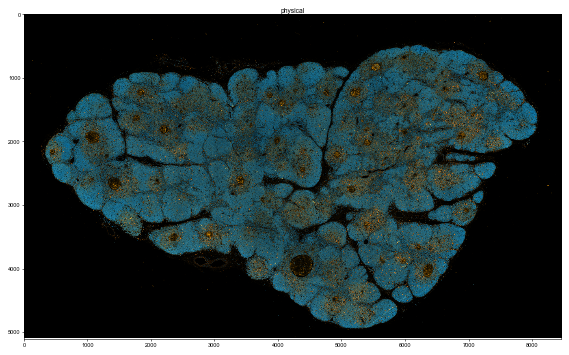

In [14]:
%%time
z17_sdata.pl.render_images(scale = 'scale5').pl.show(figsize=(7, 7), coordinate_systems="physical")

## Assign the annotation to cell labels

In [15]:
z17_sdata["table"].obs["region"] = "cell_labels"

In [16]:
z17_sdata.set_table_annotates_spatialelement(table_name="table", region="cell_labels", 
                                              region_key="region", instance_key="cell_labels")


/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/spatialdata/_core/spatialdata.py:480: UserWarning: Converting `region_key: region` to categorical dtype.
  convert_region_column_to_categorical(table)


## Define channel colors for image rendering

In [17]:
channels = z17_sdata['morphology_focus']['scale1']['c'].values.tolist()
channels.remove('dummy')

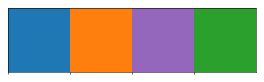

In [18]:
channel_cols = ['#1f77b4', '#ff7f0e', '#9467bd', '#2ca02c']
sns.palplot(channel_cols)

## Crop image to the relevant coordinates

In [24]:
from spatialdata import bounding_box_query
def crop_sdata(sdata_obj, xmin, xmax, ymin, ymax):
    return bounding_box_query(
        sdata_obj,
        min_coordinate=[xmin, ymin],
        max_coordinate=[xmax, ymax],
        axes=("x", "y"),
        target_coordinate_system="physical",
    )

In [21]:
scalf = 4.70588235

In [25]:
%%time
### One of the most time-consuming steps
lobule_crop = crop_sdata(z17_sdata, xmin = 3500/scalf, xmax = 7700/scalf, 
                         ymin = 7800/scalf, ymax=10750/scalf)

CPU times: user 8min 42s, sys: 2min 36s, total: 11min 19s
Wall time: 1min 28s


INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0437677816224529].


CPU times: user 2.33 s, sys: 685 ms, total: 3.02 s
Wall time: 3.27 s


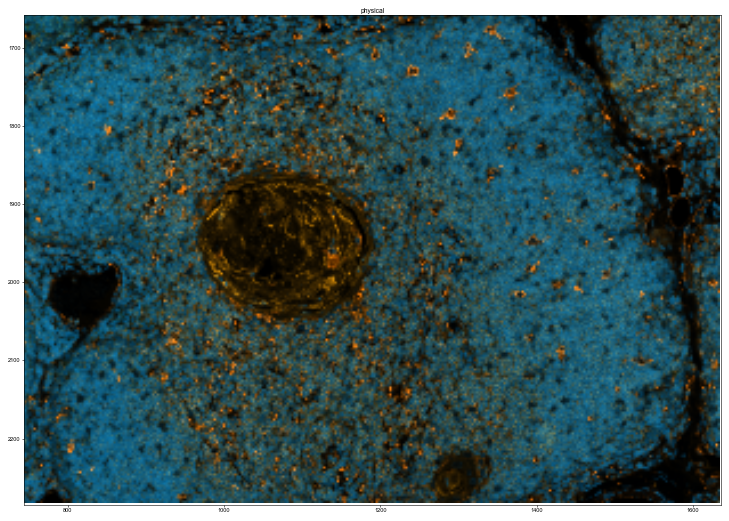

In [26]:
%%time
lobule_crop.pl.render_images(scale = 'scale1', channel = channels, palette = channel_cols).pl.show(figsize=(9, 7), coordinate_systems="physical")

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.026789696270665].


CPU times: user 2.62 s, sys: 569 ms, total: 3.18 s
Wall time: 1.45 s


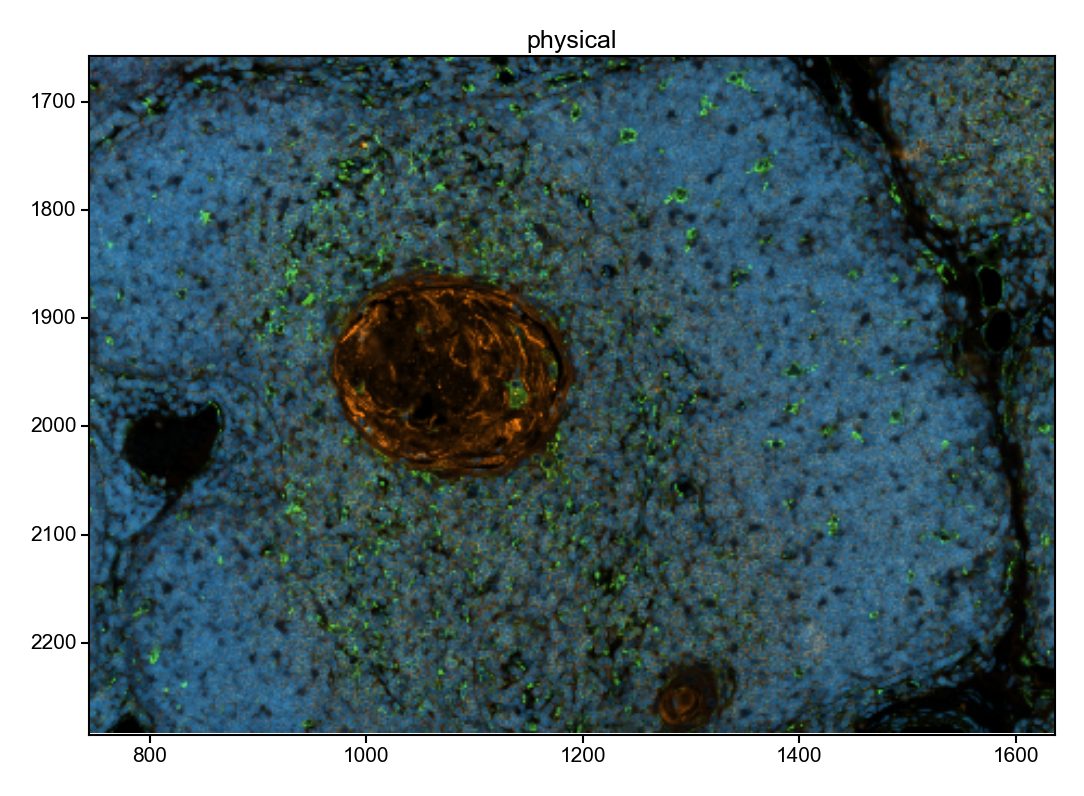

In [48]:
%%time
lobule_crop.pl.render_images(scale = 'scale1', channel = channels, palette = channel_cols).pl.show(figsize= (3.5, 4), save = f'{plot_path}/Z17_lobule_Xen_image.pdf', coordinate_systems="physical", dpi = 300)

## Render the segmentation itself

In [38]:
thyAgeing_colors

{'blue': '#648FFF',
 'purple': '#785EF0',
 'magenta': '#DC267F',
 'orange': '#FE6100',
 'yellow': '#FFB000',
 'teal': '#18868F',
 'mint': '#738B79',
 'pink': '#C169E8',
 'grass': '#82CD29',
 'forest': '#124420'}

In [43]:
tec_cols = [thyAgeing_colors['blue'],thyAgeing_colors['orange'], thyAgeing_colors['yellow'],
            thyAgeing_colors['magenta'], thyAgeing_colors['purple'], thyAgeing_colors['teal'],
            thyAgeing_colors['mint']]

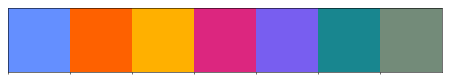

In [44]:
sns.palplot(tec_cols)

In [99]:
lobule_crop.tables['table'].obs['taa_l3'].cat.categories

Index(['T_DN(early)', 'T_DN', 'T_DP', 'T_αβT(entry)', 'T_CD8', 'T_CD4',
       'T_Treg', 'T_CD8_recirc', 'T_CD4_recirc', 'T_Treg_recirc', 'T_CD8αα',
       'T_MAIT', 'ILC', 'T_γδT', 'NK', 'cTEC', 'mcTEC', 'mTECI', 'mTECII',
       'mTECIII', 'TEC-mim', 'TEC-EMT', 'Fb-interlo', 'Fb-perilo', 'Fb-med',
       'Fb-interm', 'Fb-adipo', 'Adipocyte', 'EC-art', 'EC-cap', 'EC-ven',
       'EC-peri', 'EC-lymphatic', 'SMC', 'Pericyte', 'B_dev', 'B_naive',
       'B_mem', 'B_GC-like', 'B_plasma', 'Myeloid_dev', 'Mono', 'Mac', 'DC1',
       'DC2', 'aDC', 'pDC', 'Mast', 'none'],
      dtype='object')

In [107]:
plt.style.use('/nfs/team205/lm25/thymus_projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

In [42]:
lobule_crop.tables['table'].obs['taa_l3'].value_counts()[['cTEC', 'mcTEC', 'mTECI', 'mTECII', 'mTECIII', 'TEC-EMT']]

taa_l3
cTEC       223
mcTEC      232
mTECI      268
mTECII      83
mTECIII     46
TEC-EMT      5
Name: count, dtype: int64

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.026789696270665].
/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/spatialdata_plot/pl/utils.py:778: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


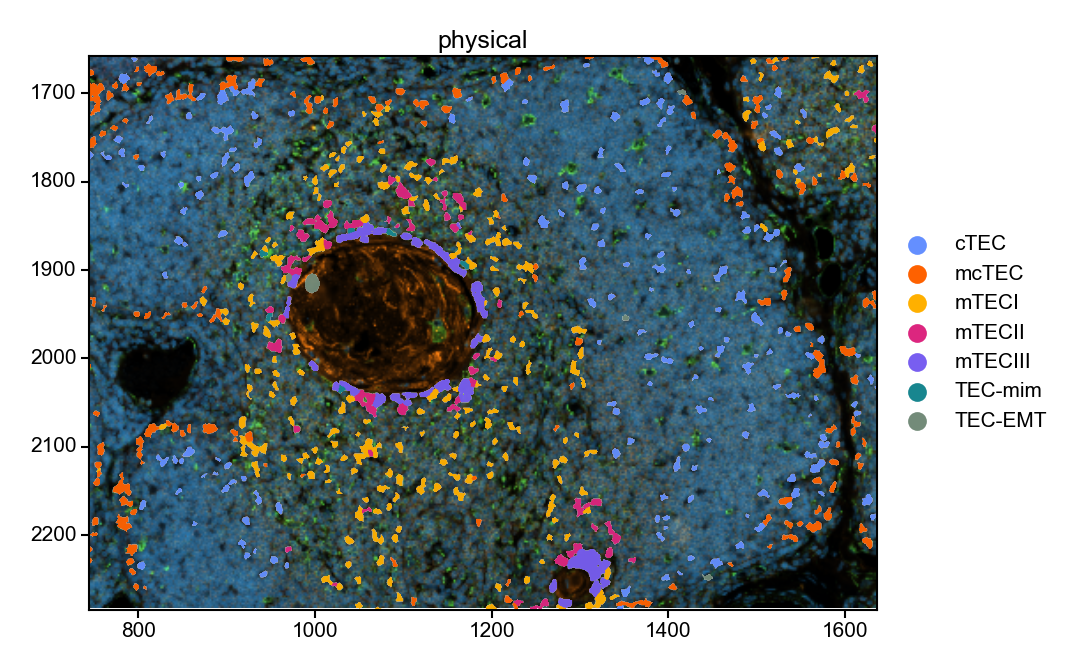

In [49]:
lobule_crop.pl.render_images(scale = 'scale1', channel = channels, palette = channel_cols).pl.render_labels(element = 'cell_labels', color = 'taa_l3', 
    groups = ['cTEC', 'mcTEC', 'mTECI', 'mTECII', 'mTECIII', 'TEC-mim', 'TEC-EMT'], 
    palette = tec_cols, fill_alpha = 0.8).pl.show(coordinate_systems="physical", figsize= (3.5, 4), save = f'{plot_path}/Z17_lobule_TECs_segmentation_cmap3_all.pdf', dpi = 300)

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.026789696270665].
/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/spatialdata_plot/pl/utils.py:778: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


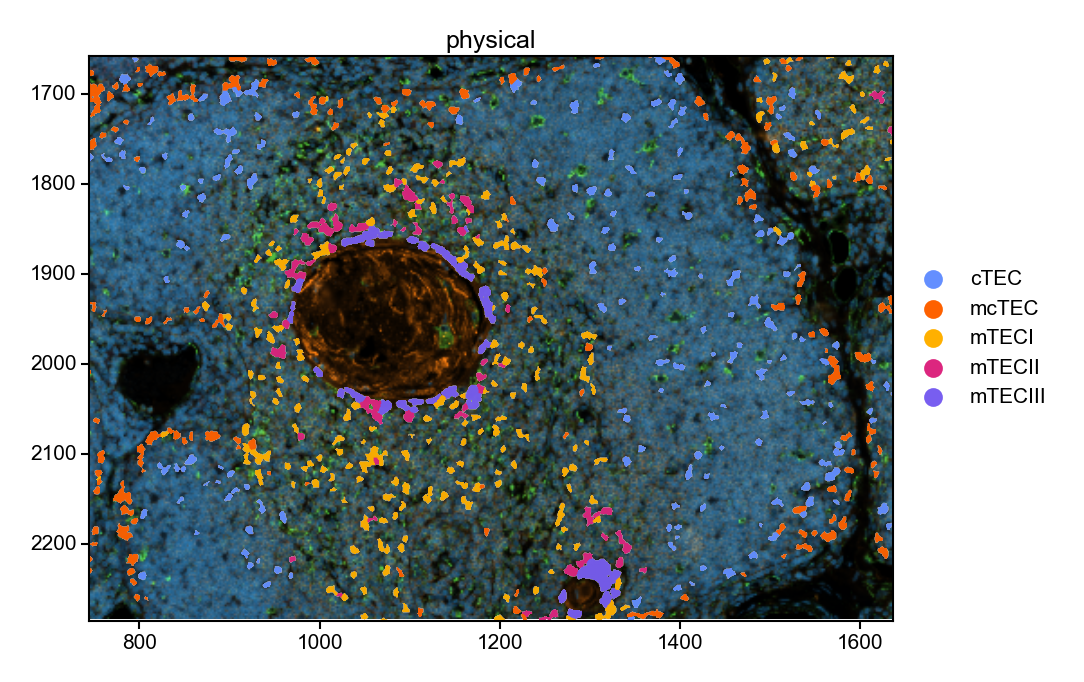

In [50]:
lobule_crop.pl.render_images(scale = 'scale1', channel = channels, palette = channel_cols).pl.render_labels(element = 'cell_labels', color = 'taa_l3', 
    groups = ['cTEC', 'mcTEC', 'mTECI', 'mTECII', 'mTECIII'], 
    palette = tec_cols[:-2], fill_alpha = 0.8).pl.show(coordinate_systems="physical", figsize= (3.5, 4), save = f'{plot_path}/Z17_lobule_TECs_segmentation_cmap3.pdf', dpi = 300)

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.026789696270665].
/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/spatialdata_plot/pl/utils.py:778: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


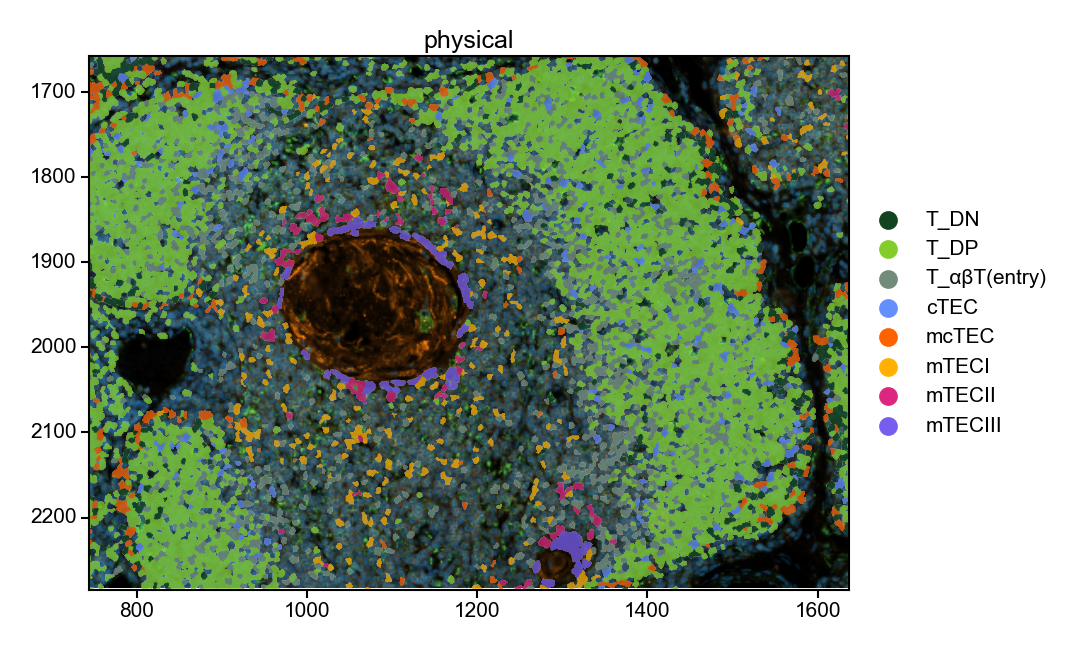

In [54]:
lobule_crop.pl.render_images(scale = 'scale1', channel = channels, palette = channel_cols).pl.render_labels(element = 'cell_labels', color = 'taa_l3', 
    groups = ['T_DN', 'T_DP', 'T_αβT(entry)', 'cTEC', 'mcTEC', 'mTECI', 'mTECII', 'mTECIII'], 
    palette = ['#124420', '#82CD29', '#738B79']+ tec_cols[:-2], fill_alpha = 0.5).pl.show(coordinate_systems="physical", figsize= (3.5, 4), save = f'{plot_path}/Z17_lobule_TECs_T_segmentation_cmap3.pdf', dpi = 300)

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.026789696270665].
/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/spatialdata_plot/pl/utils.py:778: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


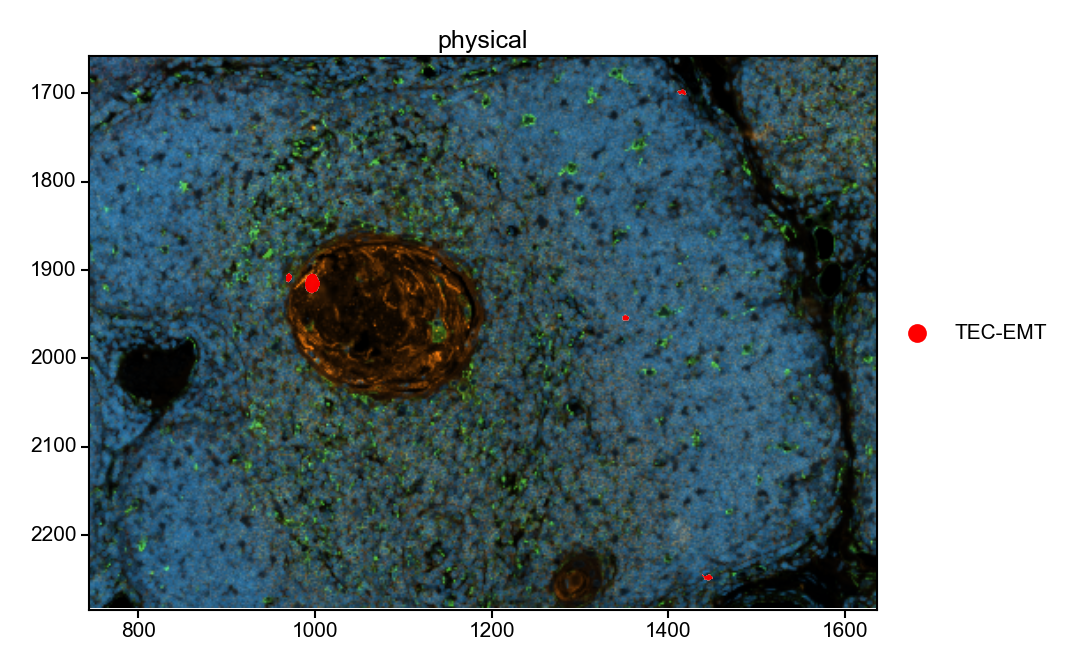

In [51]:
lobule_crop.pl.render_images(scale = 'scale1', channel = channels, palette = channel_cols).pl.render_labels(element = 'cell_labels', color = 'taa_l3', 
    groups = ['TEC-EMT'], 
    palette = 'red', fill_alpha = 0.8).pl.show(coordinate_systems="physical", figsize= (3.5, 4), save = f'{plot_path}/Z17_lobule_TECs_segmentation_EMT.pdf', dpi = 300)

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5485274894271435].
/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/spatialdata_plot/pl/utils.py:778: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


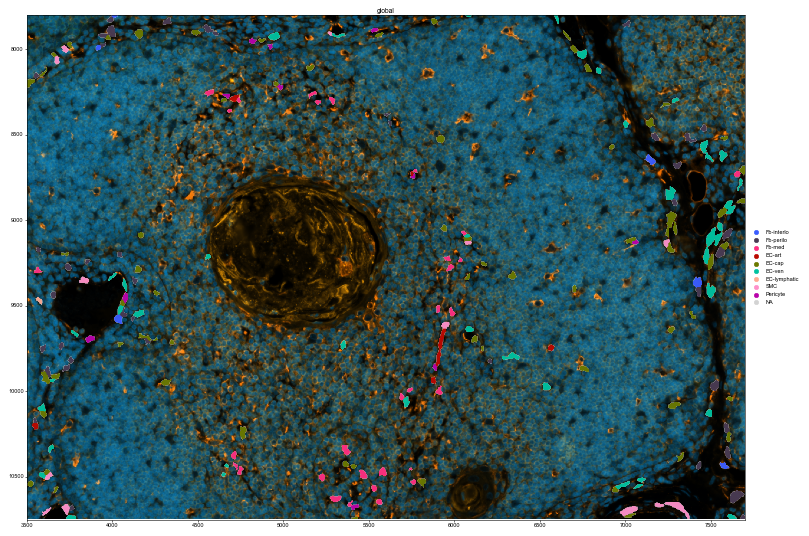

In [117]:
lobule_crop.pl.render_images(scale = 'scale1').pl.render_labels(element = 'cell_labels', color = 'taa_l3', 
    groups = ['Fb-interlo', 'Fb-perilo', 'Fb-med','EC-art', 'EC-cap', 'EC-ven',
       'EC-peri', 'EC-lymphatic', 'SMC', 'Pericyte'], 
   fill_alpha = 0.8).pl.show(coordinate_systems="global", 
    figsize=(10, 10)) #, save = f'{plot_path}/Z17_lobule_FBVasc_segmentation_overlaid.pdf', dpi = 300)

In [114]:
lobule_crop.tables['table'].obs['taa_l3'].cat.categories

Index(['T_DN(early)', 'T_DN', 'T_DP', 'T_αβT(entry)', 'T_CD8', 'T_CD4',
       'T_Treg', 'T_CD8_recirc', 'T_CD4_recirc', 'T_Treg_recirc', 'T_CD8αα',
       'T_MAIT', 'ILC', 'T_γδT', 'NK', 'cTEC', 'mcTEC', 'mTECI', 'mTECII',
       'mTECIII', 'TEC-mim', 'TEC-EMT', 'Fb-interlo', 'Fb-perilo', 'Fb-med',
       'Fb-interm', 'Fb-adipo', 'Adipocyte', 'EC-art', 'EC-cap', 'EC-ven',
       'EC-peri', 'EC-lymphatic', 'SMC', 'Pericyte', 'B_dev', 'B_naive',
       'B_mem', 'B_GC-like', 'B_plasma', 'Myeloid_dev', 'Mono', 'Mac', 'DC1',
       'DC2', 'aDC', 'pDC', 'Mast', 'none'],
      dtype='object')

In [ ]:
['Fb-interlo', 'Fb-perilo', 'Fb-med',
       'Fb-interm', 'Fb-adipo']

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.026789696270665].
/nfs/team205/vk8/mambaforge/envs/squidpy-env3/lib/python3.12/site-packages/spatialdata_plot/pl/utils.py:778: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


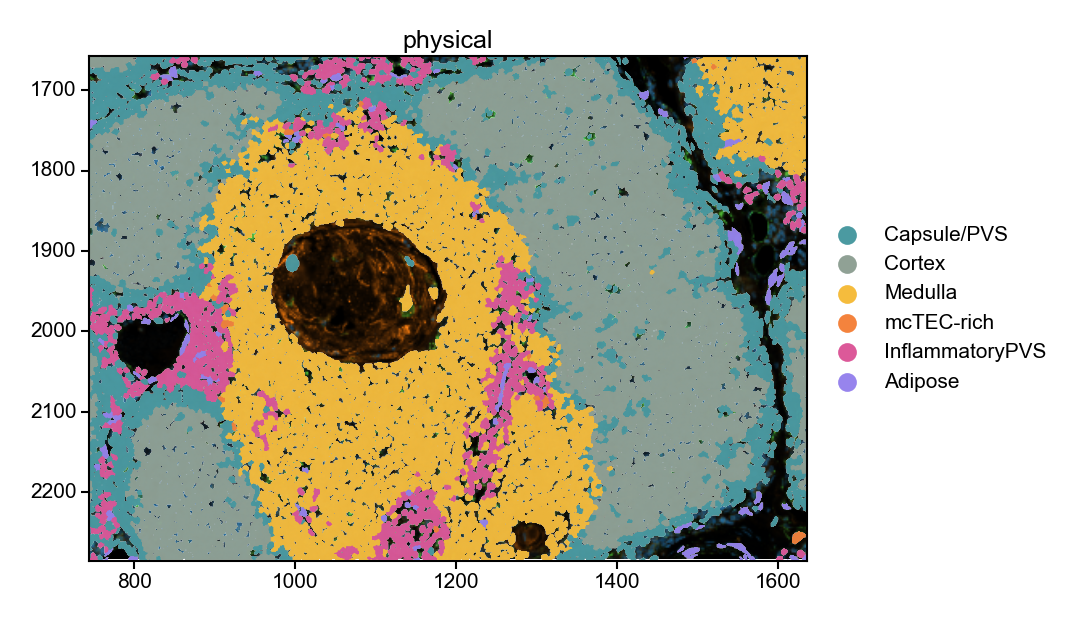

In [52]:
lobule_crop.pl.render_images(scale = 'scale1',channel = channels, palette = channel_cols).pl.render_labels(element = 'cell_labels', color = 'niche_cellcharter6', 
    fill_alpha = 0.8,  palette = tinted_niche_palette[::-1],
    groups = ['Capsule/PVS','Cortex','Medulla', 'mcTEC-rich','InflammatoryPVS', 'Adipose']).pl.show(coordinate_systems="physical", figsize=(3.5, 4),
    save = f'{plot_path}/Z17_lobule_niche_segmentation_overlaid2.pdf', dpi = 300)

In [27]:
lobule_crop.tables['table'].obs['taa_l3'].cat.categories

Index(['Adipocyte', 'B_GC-like', 'B_dev', 'B_mem', 'B_naive', 'B_plasma',
       'DC1', 'DC2', 'EC-art', 'EC-cap', 'EC-cap_lipid', 'EC-lymphatic',
       'EC-peri', 'EC-ven', 'Fb-adipo', 'Fb-interlo', 'Fb-interm', 'Fb-med',
       'Fb-perilo', 'ILC', 'Mac', 'Mast', 'Mono', 'Myeloid_dev', 'NK',
       'Neutrophil', 'Pericyte', 'SMC', 'TEC-EMT', 'TEC-mim', 'T_CD4',
       'T_CD4_recirc', 'T_CD8', 'T_CD8_recirc', 'T_CD8αα', 'T_DN',
       'T_DN(early)', 'T_DP', 'T_MAIT', 'T_Treg', 'T_Treg_recirc',
       'T_αβT(entry)', 'T_γδT', 'aDC', 'cTEC', 'mTECI', 'mTECII', 'mTECIII',
       'mcTEC', 'none', 'pDC'],
      dtype='object')